# 4 Setting the initial SoC

Setting the initial SoC for your pack is performed with an argument passed to the solve algorithm. Currently the same value is applied to each battery but in future it will be possible to vary the SoC across the pack.

In [40]:
import liionpack as lp
import pybamm
import numpy as np
import matplotlib.pyplot as plt

Lets set up the most simple pack possible with 1 battery and very low busbar resistance to compare to a pure PyBaMM simulation

In [41]:
netlist = lp.setup_circuit(Np=1, Ns=1, Rb=1.0e-8, Rc=1e-8, Ri=5e-2, V=4.0, I=5.0)

In [42]:
output_variables = [
    'X-averaged negative particle surface concentration [mol.m-3]',
    'X-averaged positive particle surface concentration [mol.m-3]',
]

# Heat transfer coefficients
htc = np.ones(1) * 10
# PyBaMM parameters
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

In [43]:
# Cycling experiment
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1 A for 1000 s or until 3.3 V",
            "Rest for 1000 s",
            "Charge at 1 A for 1000 s or until 4.0 V",
            "Rest for 1000 s",
        )
    ]
    * 3, period="10 s"
)

In [44]:
# Solve pack
output = lp.solve(netlist=netlist,
                  parameter_values=parameter_values,
                  experiment=experiment,
                  output_variables=output_variables,
                  htc=htc, initial_soc=0.5)

Solving Pack: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [00:06<00:00, 191.35it/s]


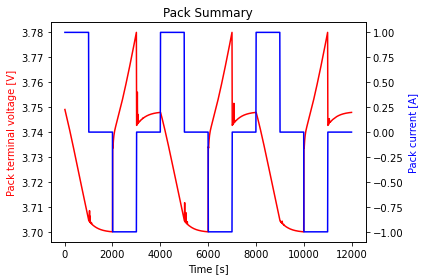

In [45]:
lp.plot_pack(output)

Let's compare to the PyBaMM simulation

In [46]:
parameter_values = pybamm.ParameterValues(chemistry=chemistry)
parameter_values.update({"Total heat transfer coefficient [W.m-2.K-1]": 10.0})
sim = lp.create_simulation(parameter_values, experiment, make_inputs=False)

In [47]:
sol = sim.solve(initial_soc=0.5)

Text(0.5, 1.0, 'Single PyBaMM Simulation')

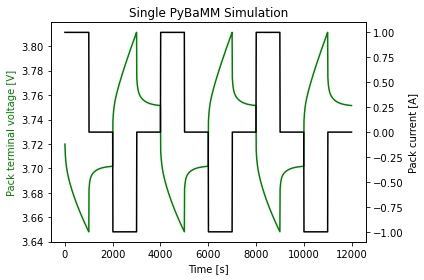

In [48]:
# Get pack level results
time = sol["Time [s]"].entries
v_pack = sol["Terminal voltage [V]"].entries
i_pack = sol["Current [A]"].entries

# Plot pack voltage and current
_, ax = plt.subplots(tight_layout=True)
ax.plot(time, v_pack, color="green", label="simulation")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Pack terminal voltage [V]", color="green")
ax2 = ax.twinx()
ax2.plot(time, i_pack, color="black", label="simulation")
ax2.set_ylabel("Pack current [A]", color="black")
ax2.set_title("Single PyBaMM Simulation")